In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from scipy import stats
from scipy.optimize import minimize, Bounds, LinearConstraint

### 19.2.5 Mean-Variance Optimization in Practice: Efficient Frontier

In this coding example, we detail how a fully invested efficient frontier can be generated and visualized using 1) analytical approach, and 2) simulation.

The portfolio is built of sector ETFs.

In [ ]:
df_price = yf.download(['XLB', 'XLF', 'XLK', 'XLP', 'XLV'], start='2000-03-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_ret = np.log(df_price/df_price.shift(1)).dropna()
df_ret

[*********************100%***********************]  5 of 5 completed


Ticker,XLB,XLF,XLK,XLP,XLV
Date,,,,,
2000-03-02,-0.022063,-0.006006,0.009917,0.002304,-0.004415
2000-03-03,0.031797,0.008996,0.027310,-0.005383,0.013733
2000-03-06,-0.024134,-0.009749,-0.001602,-0.024191,-0.019836
2000-03-07,-0.032586,-0.030607,-0.027904,-0.055209,-0.018535
2000-03-08,0.021070,-0.011723,0.017429,0.030418,-0.005115
...,...,...,...,...,...
2024-02-22,0.010013,0.011538,0.032199,0.003090,0.011688
2024-02-23,0.005891,0.004975,-0.002336,0.003080,0.004745
2024-02-26,-0.006007,-0.004975,0.000974,-0.004020,-0.005153


In [ ]:
# get annualized return and variance
ret = np.array(df_ret.mean()*252)
cov_mat = np.array(df_ret.cov())*252
print(f'Return:\n{ret}')
print(f'Covariance:\n{cov_mat}')

Return:
[0.08245767 0.05630637 0.0655326  0.07797186 0.08326465]
Covariance:
[[0.05784625 0.05004352 0.03934674 0.0215401  0.02774192]
 [0.05004352 0.08498392 0.04861817 0.02572376 0.03321246]
 [0.03934674 0.04861817 0.06634616 0.01949127 0.03108225]
 [0.0215401  0.02572376 0.01949127 0.0225312  0.01696696]
 [0.02774192 0.03321246 0.03108225 0.01696696 0.03186554]]


In [ ]:
# analytical: eq (19.39)
def plot_efficient_frontier(ret, cov_mat, N=5000):

    assert len(ret)==len(cov_mat), 'Please make sure the returns matches the shape of the covariance matrix.'

    # compute coefficients
    n = len(ret)
    a = np.ones(n).T@np.linalg.inv(cov_mat)@ret
    b = ret.T@np.linalg.inv(cov_mat)@ret
    c = np.ones(n).T@np.linalg.inv(cov_mat)@np.ones(n)
    d = b*c-a**2

    # compute optimal portfolios
    ret_arr = np.linspace(0.05,0.2,N)
    vol_arr = np.zeros(N)
    weight_arr = np.zeros((N, len(ret)))

    for i in range(N):
        w = 1/d*(c*np.linalg.inv(cov_mat)@ret-a*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[i] + 1/d*(b*np.linalg.inv(cov_mat)@np.ones(n)-a*np.linalg.inv(cov_mat)@ret)
        vol_arr[i] = np.sqrt(w.T@cov_mat@w)
        weight_arr[i,:] = w

    # plot the efficient frontier
    plt.scatter(vol_arr, ret_arr)
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.show()

    return weight_arr, ret_arr, vol_arr

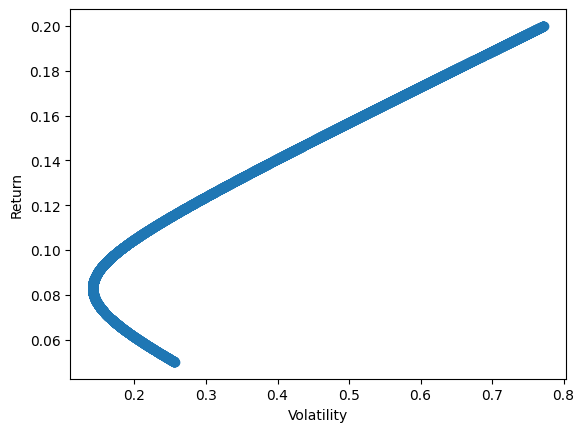

In [ ]:
_, _, _ = plot_efficient_frontier(ret, cov_mat)

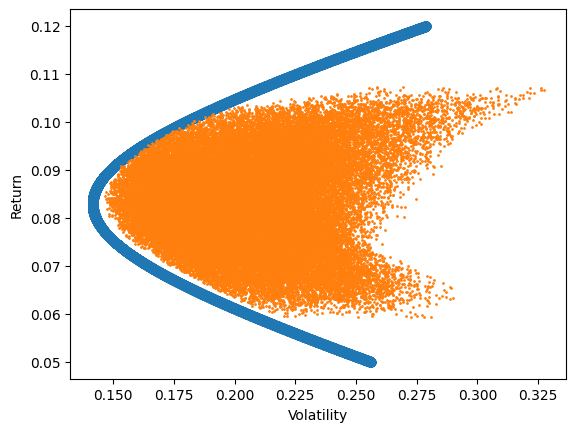

In [ ]:
# simulation
N = 50000
ret_arr1 = np.zeros(N)
vol_arr1 = np.zeros(N)

for i in range(N):
    w1 = np.array(np.random.random(len(ret)-1)-0.5)
    w2 = 1-np.sum(w1)
    w = np.append(w1, w2)
    ret_arr1[i] = np.sum(w*ret)
    vol_arr1[i] = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

ret_arr = np.linspace(0.05,0.12,N)
vol_arr = np.zeros(N)
n = len(ret)
a = np.ones(n).T@np.linalg.inv(cov_mat)@ret
b = ret.T@np.linalg.inv(cov_mat)@ret
c = np.ones(n).T@np.linalg.inv(cov_mat)@np.ones(n)
d = b*c-a**2

for i in range(N):
    w = 1/d*(c*np.linalg.inv(cov_mat)@ret-a*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[i] + 1/d*(b*np.linalg.inv(cov_mat)@np.ones(n)-a*np.linalg.inv(cov_mat)@ret)
    vol_arr[i] = np.sqrt(w.T@cov_mat@w)

plt.scatter(vol_arr, ret_arr)
plt.scatter(vol_arr1, ret_arr1, s=1)
plt.xlabel('Volatility')
plt.ylabel('Return')
plt.show()

Given a vector of expected returns and a covariance matrix, we compute the optimal portfolios under different desired expected returns using the formula given in section 19.2.4. These optimal portfolios together form the efficient frontier.  It should be emphasized that in the formulation of our optimization we enforced that the weights summed to one, or that the portfolio was fully invested.  However, we did not constrain the portfolio to be long-only.  As such, in this coding example we allow positive and negative weights, and solutions that may contain leverage.

### 19.3.2 Mean-Variance Optimization in Practice: Impact of Estimation Error

In this coding example, we show how estimation error shifts efficient forntiers and impacts expected returns and asset weights:

In [ ]:
def plot_efficient_frontiers(ret0, ret1, ret2, cov_mat, N=5000, exp_ret=0.2):

    ret_arr = np.linspace(0.05,0.2,N)
    vol_arr0 = np.zeros(N)
    vol_arr1 = np.zeros(N)
    vol_arr2 = np.zeros(N)
    w_arr0 = np.zeros((N, len(ret0)))
    w_arr1 = np.zeros((N, len(ret0)))
    w_arr2 = np.zeros((N, len(ret0)))

    n = len(ret0)
    a0 = np.ones(n).T@np.linalg.inv(cov_mat)@ret0
    a1 = np.ones(n).T@np.linalg.inv(cov_mat)@ret1
    a2 = np.ones(n).T@np.linalg.inv(cov_mat)@ret2
    b0 = ret0.T@np.linalg.inv(cov_mat)@ret0
    b1 = ret1.T@np.linalg.inv(cov_mat)@ret1
    b2 = ret2.T@np.linalg.inv(cov_mat)@ret2
    c = np.ones(n).T@np.linalg.inv(cov_mat)@np.ones(n)
    d0 = b0*c-a0**2
    d1 = b1*c-a1**2
    d2 = b2*c-a2**2

    for i in range(N):
        w0 = 1/d0*(c*np.linalg.inv(cov_mat)@ret0-a0*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[i] + 1/d0*(b0*np.linalg.inv(cov_mat)@np.ones(n)-a0*np.linalg.inv(cov_mat)@ret0)
        w1 = 1/d1*(c*np.linalg.inv(cov_mat)@ret1-a1*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[i] + 1/d1*(b1*np.linalg.inv(cov_mat)@np.ones(n)-a1*np.linalg.inv(cov_mat)@ret1)
        w2 = 1/d2*(c*np.linalg.inv(cov_mat)@ret2-a2*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[i] + 1/d2*(b2*np.linalg.inv(cov_mat)@np.ones(n)-a2*np.linalg.inv(cov_mat)@ret2)
        w_arr0[i,:] = w0
        w_arr1[i,:] = w1
        w_arr2[i,:] = w2

        vol_arr0[i] = np.sqrt(w0.T@cov_mat@w0)
        vol_arr1[i] = np.sqrt(w1.T@cov_mat@w1)
        vol_arr2[i] = np.sqrt(w2.T@cov_mat@w2)

    plt.scatter(vol_arr0, ret_arr, label='original')
    plt.scatter(vol_arr1, ret_arr, label='lower')
    plt.scatter(vol_arr2, ret_arr, label='upper')
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.legend()
    plt.show()

    exp_idx = int((exp_ret-0.05)/((0.2-0.05)/(N-1)))
    exp_w0 = w_arr0[exp_idx,:]
    exp_w1 = w_arr1[exp_idx,:]
    exp_w2 = w_arr2[exp_idx,:]

    return exp_w0, exp_w1, exp_w2

In [ ]:
# calculate the standard error of estimated return and get upper and lower boundaries
sigma_ret = np.sqrt(np.diag(cov_mat))/np.sqrt(11)
ci_lower, ci_upper = stats.norm.interval(0.9, loc=ret, scale=sigma_ret)

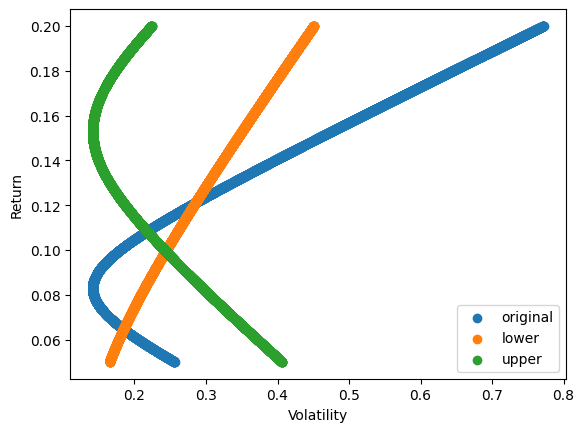

In [ ]:
exp_w0, exp_w1, exp_w2 = plot_efficient_frontiers(ret, ci_lower, ci_upper, cov_mat)

In [ ]:
df_weight = pd.DataFrame([exp_w0, exp_w1, exp_w2], index=['original', 'lower', 'upper'], columns=['XLB', 'XLF', 'XLK', 'XLP', 'XLV'])
df_weight

,XLB,XLF,XLK,XLP,XLV
original,2.659287,-3.120413,-1.888868,-0.239361,3.589354
lower,0.108806,-1.634047,-0.996609,1.854865,1.666985
upper,0.635647,0.050070,0.181260,-0.197201,0.330224


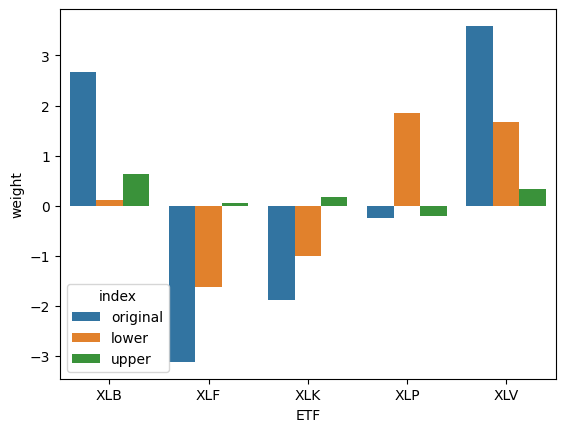

In [ ]:
# plot weights using the estimated returns
df_weight_stacked = df_weight.reset_index().melt(id_vars=['index'], value_vars=['XLB', 'XLF', 'XLK', 'XLP', 'XLV'], var_name='ETF', value_name='weight')
sns.barplot(x='ETF', y='weight', hue='index', data=df_weight_stacked)
plt.show()

### 19.3.5 Mean-Variance Optimization in Practice: Analysis of Covariance Matrices

In this coding example, we show how a covariance matrix can be inverted using historical returns of 25 stocks. Importantly, in this coding example we make sure that the inverse operation is stable by checking for negative and small, statistically insignificant eigenvalues.  These values are set to zero, and the remaining eigenvalues are rescaled.  

We begin by checking the matrix for negative eigenvalues. A negative eigenvalue implies an invalid covariance matrix, and therefore should be handled prior to inverting the matrix. Next, we calculate the relative value of each eigenvalue, which also represents the explained variance by each eigenvector, to see if all eigenvalues are statistically different from zero. A threshold is then introduced to rule out the eigenvalues and eigenvectors that are most likely to be noise. Finally, we invert the noise-free diagonal matrix $\Lambda$, enabling us to get the inverse of the covariance matrix in a stable way. The function below shows each step in order and provides visualizations for eigenvalues:

In [ ]:
def inverse_cov_mat(cov_mat, eps=1e-2, is_plot=True):

    w, v = np.linalg.eig(cov_mat)

    # check if eigenvalues are non-negative
    assert np.where(w>=0, True, False).sum()==len(w), 'Please ensure the covariance matrix is positive semi-definite.'

    # calculate relative weights and drop small eigenvalues
    weighted_w = w/np.sum(w)
    if is_plot:

        plt.plot(range(1,len(w)+1), np.sort(w)[::-1], marker='x', label='eigenvalue')
        plt.xticks(range(1,len(w)+1))
        plt.legend()
        plt.title('Eigenvalue')
        plt.show()

        plt.bar(range(1,len(w)+1), np.sort(weighted_w)[::-1], width=0.3, label='relative weight')
        plt.xticks(range(1,len(w)+1))
        plt.legend()
        plt.title('Original')
        plt.show()

    w_hat = np.where(weighted_w>=eps, w, 0)
    noise_free_w = w_hat*(np.sum(w)/np.sum(w_hat))

    # calculate inverse matrix
    inv_mat = v @ np.diag(1.0 / (np.maximum(noise_free_w, eps))) @ v.T

    if is_plot:
        plt.bar(range(1,len(w)+1), np.sort(noise_free_w)[::-1]/np.sum(noise_free_w), width=0.3, label='relative weight')
        plt.xticks(range(1,len(w)+1))
        plt.legend()
        plt.title('Noise free')
        plt.show()

    return w, noise_free_w, inv_mat

In [ ]:
stock_list = ['AAPL', 'MSFT', 'AMZN', 'GOOG', 'NVDA', 'NFLX', 'CMCSA', 'INTC', 'ADBE', 'PEP', 'CSCO', 'AVGO', 'QCOM', 'TMUS', 'COST', 'TXN', 'AMGN', 'CHTR', 'SBUX', 'AMD', 'INTU', 'AMAT', 'ISRG', 'MU', 'GILD']

df_price = yf.download(stock_list, start='2000-03-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_ret = np.log(df_price/df_price.shift(1)).dropna()
df_ret

[*********************100%***********************]  25 of 25 completed


Ticker,AAPL,ADBE,AMAT,AMD,AMGN,AMZN,AVGO,CHTR,CMCSA,COST,...,ISRG,MSFT,MU,NFLX,NVDA,PEP,QCOM,SBUX,TMUS,TXN
Date,,,,,,,,,,,,,,,,,,,,,
2010-01-06,-0.016034,-0.002124,-0.002116,-0.014523,-0.007543,-0.018282,0.007864,0.000000,-0.007194,0.012917,...,0.014405,-0.006156,0.004466,0.034535,0.006376,-0.010054,-0.009825,-0.007232,-0.069977,-0.007374
2010-01-07,-0.001851,-0.019595,-0.010650,-0.010504,-0.009199,-0.017160,-0.006286,0.000000,0.020840,-0.004845,...,-0.003759,-0.010454,-0.034455,-0.017405,-0.019792,-0.006376,0.028580,-0.002566,0.009352,0.003112
2010-01-08,0.006627,-0.005436,0.037819,-0.004233,0.008847,0.026717,0.007331,-0.043803,-0.002951,-0.007227,...,-0.005520,0.006873,0.023702,0.017031,0.002159,-0.003286,0.009954,-0.003430,-0.057471,0.022654
2010-01-11,-0.008861,-0.013169,0.021755,-0.031236,0.004394,-0.024335,0.006240,0.000000,-0.006523,0.001180,...,0.007513,-0.012802,-0.018182,-0.001314,-0.014115,-0.001153,-0.003645,-0.003012,0.012597,-0.012992
2010-01-12,-0.011440,-0.015306,-0.046104,-0.055101,-0.017515,-0.022977,-0.015148,0.000000,-0.018008,-0.005406,...,-0.022415,-0.006629,-0.060510,-0.016289,-0.034486,0.013906,-0.016364,-0.016946,-0.124236,-0.042827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-02-22,0.011181,-0.001766,0.048207,0.101604,0.006049,0.034913,0.061188,0.033205,0.001433,0.015617,...,0.023009,0.023274,0.052820,0.026030,0.151870,-0.003441,0.017865,0.007967,-0.003053,0.008194
2024-02-23,-0.010085,0.029094,-0.012951,-0.029803,0.013929,0.002346,-0.006559,0.008115,-0.000238,0.004795,...,0.001772,-0.003187,0.001047,-0.008379,0.003546,0.007992,0.001033,-0.001672,0.004819,-0.010574
2024-02-26,-0.007479,0.012640,0.031896,-0.002893,-0.009765,-0.001487,0.009795,-0.022904,0.006897,0.010005,...,-0.003856,-0.006847,0.039444,0.006984,0.003483,-0.007932,0.013592,-0.014113,-0.002620,0.003720


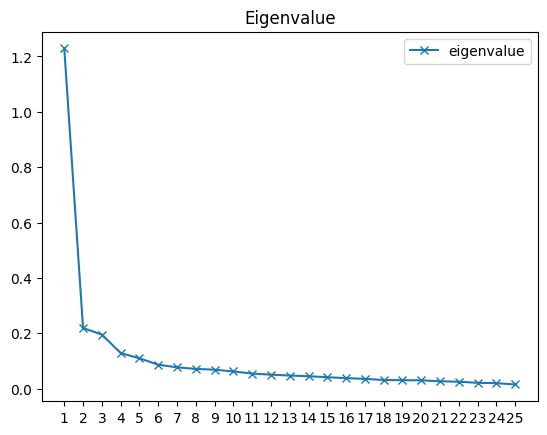

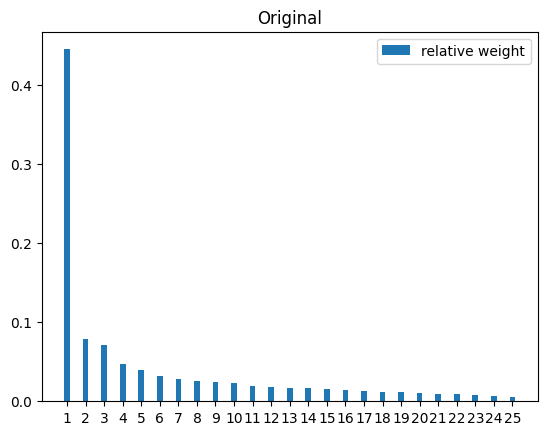

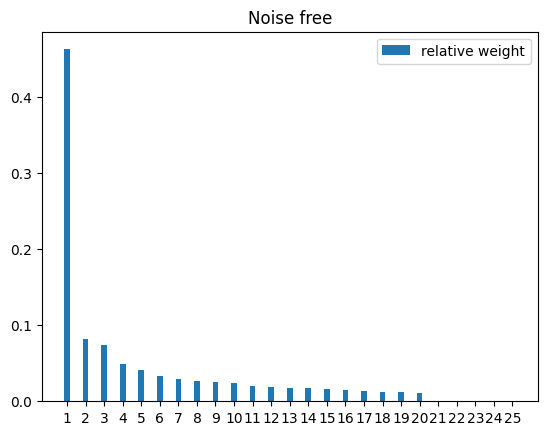

In [ ]:
cov_mat_stock = df_ret.dropna().cov().values*252
w, noise_free_w, inv_mat = inverse_cov_mat(cov_mat_stock)

### 19.4.4 CAPM in Practice: Efficient Frontier, Tangency Portfolio and Leverage

In section 19.2.3, we show how to compute the optimal portfolio given an expected return. In order to find the tangency portfolio on the efficient frontier, we just need to go one step further. That is, compute the Sharpe Ratio for each optimal portfolio and pick the portfolio with highest Sharpe. We can build on top of the `plot_efficient_frontier()` function above, and use the following snippet to locate the tangency portfolio:

```python
sharpe_arr = ret_arr / vol_arr
tan_idx = sharpe_arr.argmax()       # sharpe_arr contains SR of all portfolios on the efficient frontier
tan_weight = weight_arr[tan_idx,:]  # weight_arr stores the weight vector for all portfolios on the efficient frontier
tan_ret = ret_arr[tan_idx]
tan_vol = vol_arr[tan_idx]
```

The function below visualizes the efficient frontier, the Capital Market Line, and the tangency portfolio using the data of ETF portfolio as in 19.2.5.

In [ ]:
def plot_eff_cal(rf, ret, cov_mat, N=5000):

    assert len(ret)==len(cov_mat), 'Please make sure the returns matches the shape of the covariance matrix.'

    # compte coefficients
    n = len(ret)
    a = np.ones(n).T@np.linalg.inv(cov_mat)@ret
    b = ret.T@np.linalg.inv(cov_mat)@ret
    c = np.ones(n).T@np.linalg.inv(cov_mat)@np.ones(n)
    d = b*c-a**2

    # compute optimal portfolios
    weight_arr = np.zeros((N, n))
    ret_arr = np.linspace(0.05,0.15,N)
    vol_arr = np.zeros(N)
    sharpe_arr = np.zeros(N)

    for i in range(N):
        w = 1/d*(c*np.linalg.inv(cov_mat)@ret-a*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[i] + 1/d*(b*np.linalg.inv(cov_mat)@np.ones(n)-a*np.linalg.inv(cov_mat)@ret)
        weight_arr[i,:] = w
        vol_arr[i] = np.sqrt(w.T@cov_mat@w)
        sharpe_arr[i] = (ret_arr[i]-rf)/vol_arr[i]

    # compute the tangency portfolio
    tan_idx = sharpe_arr.argmax()
    tan_weight = weight_arr[tan_idx,:]
    tan_ret = ret_arr[tan_idx]
    tan_vol = vol_arr[tan_idx]

    # compute the Capital Allocation Line
    x_arr = []
    y_arr = []
    for x in np.linspace(0, vol_arr[-1], N):
        x_arr.append(x)
        slope = (tan_ret-rf)/tan_vol
        y = slope*x + rf
        y_arr.append(y)

    # plot the efficient frontier with CAL
    plt.scatter(vol_arr, ret_arr, s=5)
    plt.xlabel('Volatility')
    plt.ylabel('Return')
    plt.scatter(tan_vol, tan_ret, s=50)
    plt.scatter(x_arr, y_arr, s=0.25)
    plt.show()

    return tan_weight, (tan_vol, tan_ret)

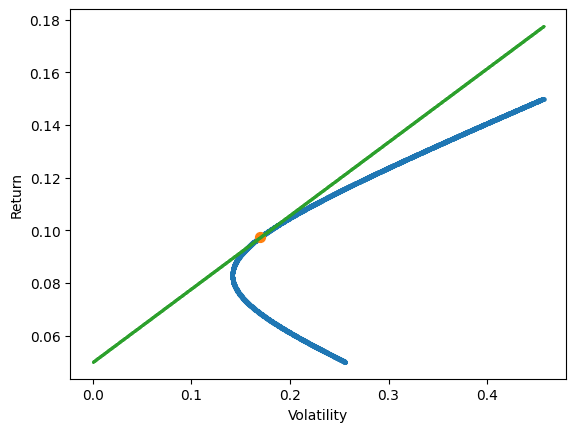

In [ ]:
w, loc = plot_eff_cal(0.05, ret, cov_mat)

### 19.6.2 Resampling in Practice: Comparison to a Mean-Variance Efficient Frontier

This coding example computes a resampled efficient frontier under the assumption that return are jointly normal. For each simulation of the multi-variate normal distribution, we formulate a joint path for all underlying assets using the given mean and covariance of the returns. This will imply a new mean return and a new covariance matrix specific to each simulated path. We can then make use of previous developed functions to compute the efficient frontier along each simulated path. After iterating through all simulated, an average weight vector is computed, which is our resampled efficient frontier:

In [ ]:
def resampled_efficient_frontier(ret, cov_mat, size=252, N_path=1000, N_point=5000):

    assert len(ret)==len(cov_mat), 'Please make sure the returns matches the shape of the covariance matrix.'
    n = len(ret)
    ret_arr = np.linspace(0,0.3,N_point)
    vol_arr = np.zeros(N_point)
    weight_arr_all = np.zeros((N_path,N_point,n))

    for i in range(N_path):

        # generate resampled paths
        data = np.random.multivariate_normal(ret, cov_mat, size=size)
        ret_i = data.mean(axis=0)
        cov_mat_i = np.cov(data.T)

        weight_arr = np.zeros((N_point,n))
        a = np.ones(n).T@np.linalg.inv(cov_mat_i)@ret_i
        b = ret_i.T@np.linalg.inv(cov_mat_i)@ret_i
        c = np.ones(n).T@np.linalg.inv(cov_mat_i)@np.ones(n)
        d = b*c-a**2

        # compute the efficient frontier
        for j in range(N_point):
            w = 1/d*(c*np.linalg.inv(cov_mat_i)@ret_i-a*np.linalg.inv(cov_mat_i)@np.ones(n))*ret_arr[j] + 1/d*(b*np.linalg.inv(cov_mat_i)@np.ones(n)-a*np.linalg.inv(cov_mat_i)@ret_i)
            weight_arr[j,:] = w

        weight_arr_all[i,:] = weight_arr

    # average the weights of multiple efficient frontiers
    avg_weight_arr = weight_arr_all.mean(axis=0)

    for k in range(N_point):
        w = avg_weight_arr[k,:]
        vol_arr[k] = np.sqrt(w.T@cov_mat@w)

    return ret_arr, vol_arr

We can then plot the resampled efficient frontier and compare this to the standard efficient frontier. We use the same data of sector ETF portfolios as in 19.2.5.

In [ ]:
def compare_efficient_frontier(ret, cov_mat, size=252, N_path=1000, N_point=5000, is_plot=True):

    assert len(ret)==len(cov_mat), 'Please make sure the returns matches the shape of the covariance matrix.'
    n = len(ret)
    ret_arr = np.linspace(0.05,0.2,N_point)
    vol_arr = np.zeros(N_point)
    weight_arr_all = np.zeros((N_path,N_point,n))
    ret_arr_resmpl = np.zeros(N_point)

    for i in range(N_path):

        # generate resampled paths
        data = np.random.multivariate_normal(ret, cov_mat, size=size)
        ret_i = data.mean(axis=0)
        cov_mat_i = np.cov(data.T)

        weight_arr = np.zeros((N_point,n))
        a = np.ones(n).T@np.linalg.inv(cov_mat_i)@ret_i
        b = ret_i.T@np.linalg.inv(cov_mat_i)@ret_i
        c = np.ones(n).T@np.linalg.inv(cov_mat_i)@np.ones(n)
        d = b*c-a**2

        # compute the efficient frontier
        for j in range(N_point):
            w = 1/d*(c*np.linalg.inv(cov_mat_i)@ret_i-a*np.linalg.inv(cov_mat_i)@np.ones(n))*ret_arr[j] + 1/d*(b*np.linalg.inv(cov_mat_i)@np.ones(n)-a*np.linalg.inv(cov_mat_i)@ret_i)
            weight_arr[j,:] = w

        weight_arr_all[i,:] = weight_arr

    # average the weights of multiple efficient frontiers
    avg_weight_arr = weight_arr_all.mean(axis=0)

    for k in range(N_point):
        w = avg_weight_arr[k,:]
        vol_arr[k] = np.sqrt(w.T@cov_mat@w)
        ret_arr_resmpl[k] = w.T@ret

    # mean-variance efficient frontier
    vol_arr0 = np.zeros(N_point)
    a = np.ones(n).T@np.linalg.inv(cov_mat)@ret
    b = ret.T@np.linalg.inv(cov_mat)@ret
    c = np.ones(n).T@np.linalg.inv(cov_mat)@np.ones(n)
    d = b*c-a**2
    for s in range(N_point):
        w = 1/d*(c*np.linalg.inv(cov_mat)@ret-a*np.linalg.inv(cov_mat)@np.ones(n))*ret_arr[s] + 1/d*(b*np.linalg.inv(cov_mat)@np.ones(n)-a*np.linalg.inv(cov_mat)@ret)
        vol_arr0[s] = np.sqrt(w.T@cov_mat@w)

    if is_plot:
        plt.figure(figsize=(12,8))
        plt.scatter(vol_arr, ret_arr_resmpl, s=0.25, label='resampled')  # resampled eff frontier
        plt.scatter(vol_arr0, ret_arr, s=0.25, label='original')         # mean-variance eff frontier
        plt.xlabel('Volatility')
        plt.ylabel('Return')
        plt.legend(markerscale=10)
        plt.show()

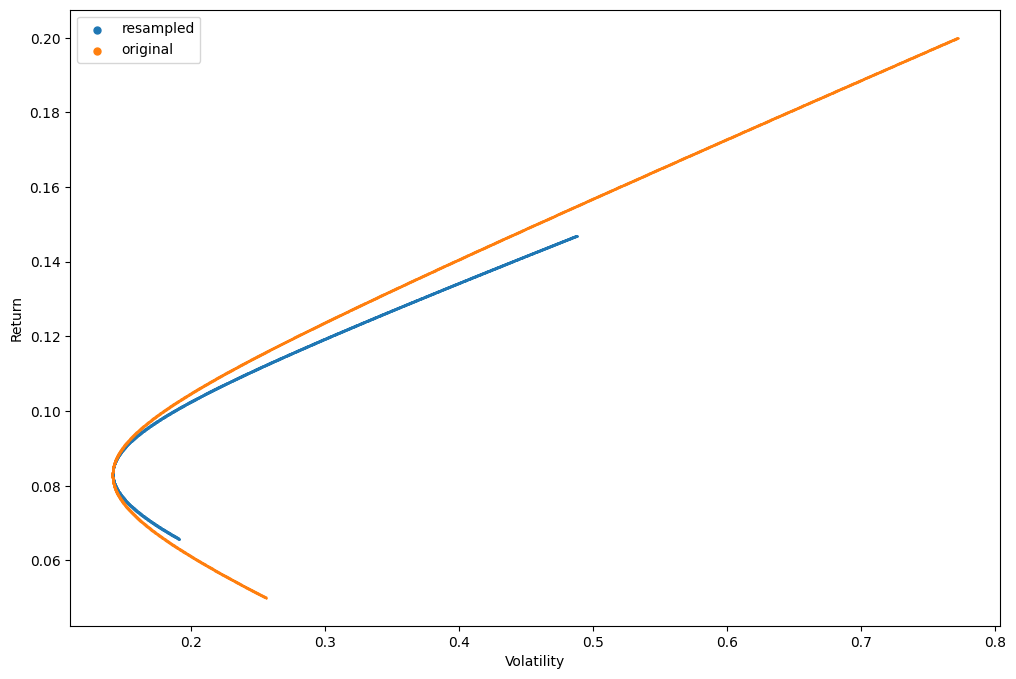

In [ ]:
compare_efficient_frontier(ret, cov_mat, N_path=10)

### 19.9.6 Asset Class Risk Parity Portfolio in Practice

In this coding example, we detail how to find an equal risk contribution portfolio. The function `rc_err()` computea the sum of squared distance from equal risk contributions given a weight vector $w$ and covariance matrix $\Sigma$.  We then use `scipy.optimize` to minimize the distance from equal risk contributions.  We further assume a long-only portfolio that does not contain leverage.  To do this, we make sure the weights $0 \leq w_i \leq 1$ using `Bounds` and further that they sum to one using `LinearConstraint`.

In [ ]:
def rc_err(w):

    n_asset = len(cov_mat)
    denom = np.sqrt(w.T@cov_mat@w)
    numer = np.zeros(n_asset)
    rc = np.zeros(n_asset)

    for j in range(n_asset):
        numer[j] = w[j]*(cov_mat@w)[j]
        rc[j] = numer[j]/denom

    avg_rc = np.sum(rc)/n_asset
    err = rc - avg_rc
    squared_err = np.sum(err**2)

    return squared_err

In [ ]:
df_price = yf.download(['SPY', 'GOVT', 'HYG', 'DBC'], start='2016-03-01', end='2024-02-29', auto_adjust=False)['Adj Close']
df_ret = np.log(df_price/df_price.shift(1)).dropna()
cov_mat = np.array(df_ret.cov())*252

[*********************100%***********************]  4 of 4 completed


In [ ]:
bounds = Bounds([0.0]*len(cov_mat), [1.0]*len(cov_mat))
sum_constraint = LinearConstraint([1.0]*len(cov_mat), [1.0], [1.0])
w0 = np.array([1.0/len(cov_mat)]*len(cov_mat))
res = minimize(rc_err, w0, method='trust-constr', constraints=sum_constraint, bounds=bounds)
print(res.x)

[0.12660747 0.57302946 0.18985089 0.11051218]


In [ ]:
# expected portfolio return
print(df_ret.dot(res.x).mean()*252)

0.0346210717539562


In [ ]:
# expected portfolio vol
print(df_ret.dot(res.x).std()*np.sqrt(252))

0.05412197792438487


It should be emphasized that this implement of a risk parity, or equal risk contribution portfolio does not include leverage.  We could then add leverage to the portfolio by simply rescaling the weights, and adding a corresponding short position in cash, or the risk-free asset.

### 19.11 Case Study: Risk Parity and the post-Covid Inflation Shock

Following 19.9.6, we build a risk parity portfolio consisting stocks, bonds, high yield, and commodities with fixed weights, and backtest portfolio return during 01/01/2022 and 06/01/2022. Similarly, we bulid another risk parity portfolio but with stocks, bonds, and high yield only, and backtest on the same period. We will plot their daily returns against the benchmark, RPAR.

In [ ]:
# load historical data
df_price = yf.download(['SPY', 'GOVT', 'HYG', 'DBC'], start='2016-03-01', end='2021-12-31', auto_adjust=False)['Adj Close']
df_ret = np.log(df_price/df_price.shift(1)).dropna()
df_ret = df_ret[['SPY', 'GOVT', 'HYG', 'DBC']]
cov_mat1 = np.array(df_ret.cov())*252
cov_mat2 = np.array(df_ret[['SPY', 'GOVT', 'HYG']].cov())*252

[*********************100%***********************]  4 of 4 completed


In [ ]:
# get weights
cov_mat = cov_mat1
bounds1 = Bounds([0.0]*len(cov_mat1), [1.0]*len(cov_mat1))
sum_constraint1 = LinearConstraint([1.0]*len(cov_mat1), [1.0], [1.0])
w0_1 = np.array([1.0/len(cov_mat1)]*len(cov_mat1))
res1 = minimize(rc_err, w0_1, method='trust-constr', constraints=sum_constraint1, bounds=bounds1)
print(res1.x)

cov_mat = cov_mat2
bounds2 = Bounds([0.0]*len(cov_mat2), [1.0]*len(cov_mat2))
sum_constraint2 = LinearConstraint([1.0]*len(cov_mat2), [1.0], [1.0])
w0_2 = np.array([1.0/len(cov_mat2)]*len(cov_mat2))
res2 = minimize(rc_err, w0_2, method='trust-constr', constraints=sum_constraint2, bounds=bounds2)
print(res2.x)

[0.09057544 0.64494871 0.16521309 0.09926277]
[0.11535007 0.67561005 0.20903989]


In [ ]:
# calculate portfolio returns
df_price_2022 = yf.download(['SPY', 'GOVT', 'HYG', 'DBC'], start='2022-01-01', end='2022-06-01', auto_adjust=False)['Adj Close']
df_ret_2022 = np.log(df_price_2022/df_price_2022.shift(1)).dropna()
df_ret_2022 = df_ret_2022[['SPY', 'GOVT', 'HYG', 'DBC']]
df_port1_ret = df_ret_2022.dot(res1.x).to_frame(name='Portfolio_Return')                           # stocks/bonds/high yield/commodities
df_port2_ret = df_ret_2022[['SPY', 'GOVT', 'HYG']].dot(res2.x).to_frame(name='Portfolio_Return')   # stocks/bonds/high yield

[*********************100%***********************]  4 of 4 completed


In [ ]:
# volatility check
vol_spy = np.sqrt(np.diagonal(cov_mat1))[0]
vol_port1 = np.sqrt(res1.x@cov_mat1@res1.x)
vol_port2 = np.sqrt(res2.x@cov_mat2@res2.x)

print(f'SPY volatility: {vol_spy.round(4)}')
print(f'Portfolio 1 volatility: {vol_port1.round(4)}')
print(f'Portfolio 2 volatility: {vol_port2.round(4)}')

SPY volatility: 0.18
Portfolio 1 volatility: 0.0396
Portfolio 2 volatility: 0.0383


In [ ]:
# cumulated return
scale_factor = 4   # ~0.15 vol

df_spy_cumsum = np.cumsum(df_ret_2022[['SPY']])
df_port1_cumsum = np.cumsum(df_port1_ret)*scale_factor
df_port2_cumsum = np.cumsum(df_port2_ret)*scale_factor

print(f'SPY return: {df_spy_cumsum.values[-1][0].round(4)}')
print(f'Portfolio 1 return: {df_port1_cumsum.values[-1][0].round(4)}')
print(f'Portfolio 2 return: {df_port2_cumsum.values[-1][0].round(4)}')

SPY return: -0.1426
Portfolio 1 return: -0.1772
Portfolio 2 return: -0.3422


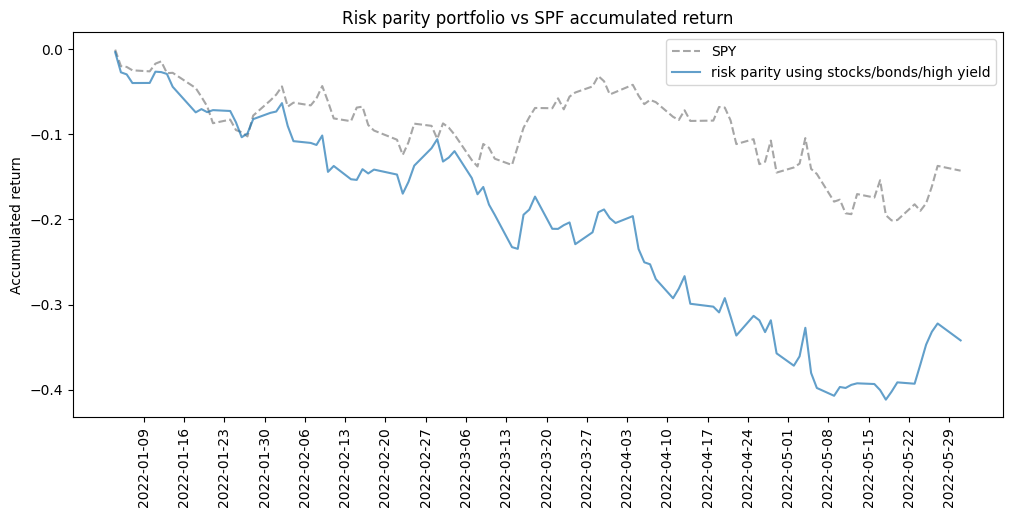

In [ ]:
# visualization
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_spy_cumsum['SPY'], color='gray', linestyle='--', alpha=0.7, label='SPY')
ax.plot(df_port2_cumsum['Portfolio_Return'], alpha=0.7, label='risk parity using stocks/bonds/high yield')
ticks_range = pd.date_range(df_port1_ret.index.min(), df_port1_ret.index.max(), freq='W', inclusive='both')
plt.xticks(ticks_range, rotation=90)
plt.ylabel('Accumulated return')
plt.title('Risk parity portfolio vs SPF accumulated return')
plt.legend()
plt.show()

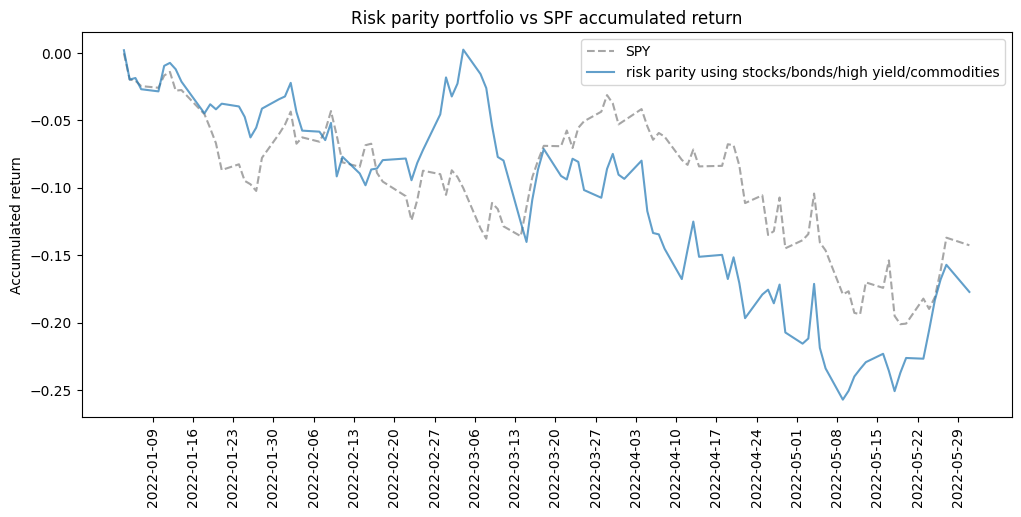

In [ ]:
fig, ax = plt.subplots(figsize=(12,5))
ax.plot(df_spy_cumsum['SPY'], color='gray', linestyle='--', alpha=0.7, label='SPY')
ax.plot(df_port1_cumsum['Portfolio_Return'], alpha=0.7, label='risk parity using stocks/bonds/high yield/commodities')
ticks_range = pd.date_range(df_port1_ret.index.min(), df_port1_ret.index.max(), freq='W', inclusive='both')
plt.xticks(ticks_range, rotation=90)
plt.ylabel('Accumulated return')
plt.title('Risk parity portfolio vs SPF accumulated return')
plt.legend()
plt.show()